In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from geemap import ml
from sklearn.ensemble import RandomForestClassifier

import geemap, ee

from geemap import cartoee
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

from matplotlib.pyplot import Line2D

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
    accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.model_selection import RandomizedSearchCV

In [3]:
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()


Successfully saved authorization token.


In [4]:
%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../lib/')

In [5]:
%reload_ext autoreload
import sand_classification as sc
import quality_mosaic as qm
import train_val as tv

# Train a set of classifiers

In [6]:
test_split=0.3
seed_segmentation = 15

In [7]:
filename = '../data/labels/gt-bands-resampled-s' + str(seed_segmentation)+'.xlsx'
filename

'../data/labels/gt-bands-resampled-s15.xlsx'

In [20]:
X_train, X_test, y_train,  y_test = tv.split(filename, test_split=test_split)


Train test split:  113 : 49


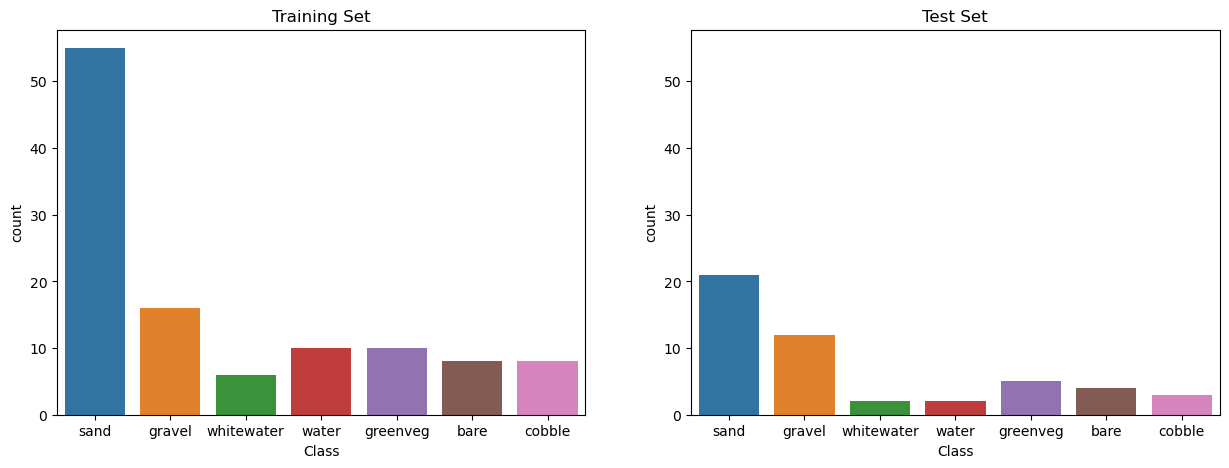

In [9]:
#plot the distribution of the classes in X_train and X_test using the column class_code
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='class_code', data=X_train, ax=ax[0])
sns.countplot(x='class_code', data=X_test, ax=ax[1])
ax[0].set_title('Training Set')
ax[1].set_title('Test Set')

ax[0].set_xticklabels(tv.class_labels)
ax[1].set_xticklabels(tv.class_labels)

ax[0].set_xlabel('Class')
ax[1].set_xlabel('Class')
#set their y axes to be the same size

ax[1].set_ylim(ax[0].get_ylim())
# plt.title('Label Distribution')

plt.show()


In [189]:
len(X_test), len(X_train)

(49, 113)

## Plot global locations of train/test samples

In [63]:
Map = geemap.Map()

Map.add_basemap('SATELLITE')

image = (
    ee.ImageCollection('MODIS/MCD43A4_006_NDVI')
    .filter(ee.Filter.date('2022-04-01', '2022-05-01'))
    .select("NDVI")
    .median()
)

vis_params = {
    'min': 0.0,
    'max': 1.0,
    'palette': [
        'FFFFFF',
        'CE7E45',
        'DF923D',
        'F1B555',
        'FCD163',
        '99B718',
        '74A901',
        '66A000',
        '529400',
        '3E8601',
        '207401',
        '056201',
        '004C00',
        '023B01',
        '012E01',
        '011D01',
        '011301',
    ],
}
# Map.setCenter(-7.03125, 31.0529339857, 2)
# Map.addLayer(image, vis_params, 'MODIS NDVI')

countries = ee.FeatureCollection('users/giswqs/public/countries')
style = {"color": "00000088", "width": 1, "fillColor": "00000000"}
Map.addLayer(countries.style(**style), {}, "Countries")

ndvi = image.visualize(**vis_params)
blend = ndvi.blend(countries.style(**style))



Map.addLayer(blend, {}, "Blend")


train_locations, test_locations = [], []

for i, row in X_train.iterrows():
    train_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))

for i, row in X_test.iterrows():
    test_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))


#convert the list of features to a feature collection
train_samples = ee.FeatureCollection(train_locations)
test_samples = ee.FeatureCollection(test_locations)

Map.addLayer(train_samples, {'color':'blue'}, 'training locations')
Map.addLayer(test_samples, {'color':'red'}, 'testing locations')




Map

KeyError: 'Longitude'

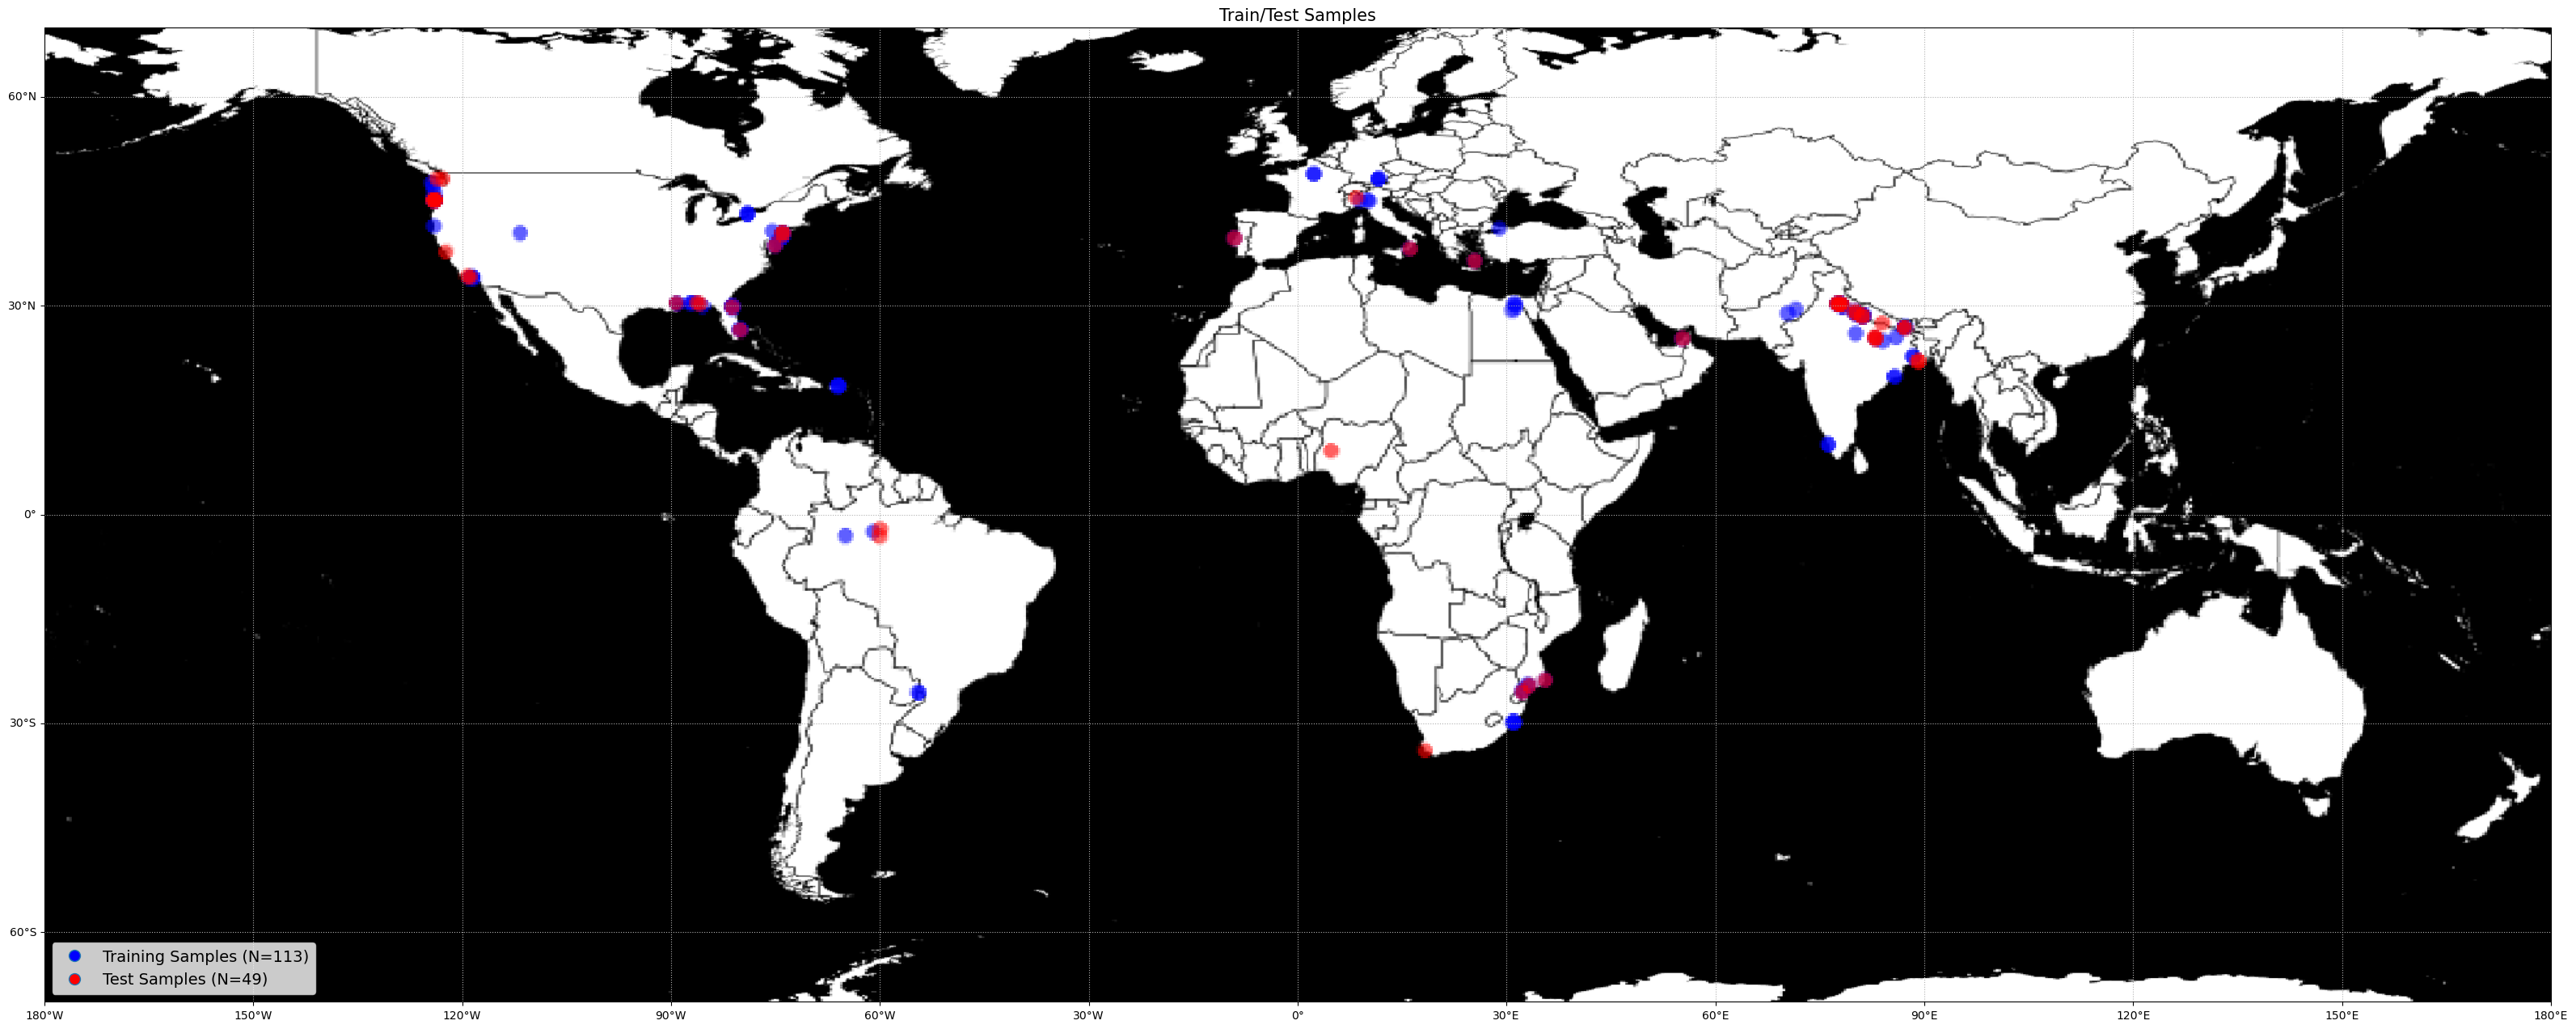

In [67]:
# specify region to focus on
bbox = [180, -70, -180, 70]
basemap = cimgt.Stamen('watercolor')
basemap = 'ROADMAP'
basemap = cimgt.Stamen('terrain-background')
basemap = cimgt.Stamen('toner-background')
# basemap = 'SATELLITE'

countries = ee.FeatureCollection('users/giswqs/public/countries')
countries_layer = countries.draw(color = 'black', strokeWidth = 1)

train_locations, test_locations = [], []

for i, row in X_train.iterrows():
    train_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))

for i, row in X_test.iterrows():
    test_locations.append(ee.Feature(ee.Geometry.Point(row['Longitude'], row['Latitude']), {'class_code': row['class_code']}))


#convert the list of features to a feature collection
train_samples = ee.FeatureCollection(train_locations)
test_samples = ee.FeatureCollection(test_locations)

fig = plt.figure(figsize=(40, 20))
projection = ccrs.EqualEarth(central_longitude=-180)
# plot the result with cartoee using a PlateCarre projection (default)
# ax = cartoee.get_map(blend, region=bbox, projection=projection, basemap=basemap)

ax = cartoee.get_map(train_samples.draw(color = 'blue', strokeWidth = 0, pointRadius=3), region=bbox, projection=projection, basemap=basemap)
# cartoee.add_layer(ax, train_samples.draw(color = 'blue', strokeWidth = 0, pointRadius=3), region=bbox)
cartoee.add_layer(ax, test_samples.draw(color = 'red', strokeWidth = 0, pointRadius=3), region=bbox)

cartoee.add_gridlines(ax, interval=30, linestyle=":") #xtick_rotation=0, 


legend_elements = [
                Line2D([],[],marker="o",
                    markerfacecolor='blue',
                    label="Training Samples (N=113)",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls=""),
                Line2D([],[],marker="o",
                    markerfacecolor='red',
                    label="Test Samples (N=49)",
                    # markerfacecolor="#A8321D",
                    markersize=10,
                    ls="")          
            ]
legend = cartoee.add_legend(ax, legend_elements, loc='lower left')


ax.set_title(label='Train/Test Samples', fontsize=15)

plt.savefig('../data/labels/sample-locations.jpg', dpi=600)
plt.show()

# Hyperparameter Tuning

In [14]:
rgb_cols = ['B2_mean','B3_mean','B4_mean']

In [21]:
X_train = X_train.drop(['Latitude', 'Longitude', 'class_code'], axis=1)
X_test  = X_test.drop(['Latitude', 'Longitude', 'class_code'], axis=1)

X_train, X_test = X_train[rgb_cols], X_test[rgb_cols]

X_train, X_test, y_train, y_test

(         B2_mean      B3_mean      B4_mean
 103  3604.081643  3701.312909  2405.808055
 55   1331.187378  2068.615479  2863.751709
 132   373.928314   430.720581   299.316162
 118   187.556442   662.162354   257.104950
 137   144.179565   287.100739   151.528473
 ..           ...          ...          ...
 153  2111.152344  2560.042969  2801.894043
 98   1407.175537  1603.819946  1361.244385
 16   3359.559082  3448.769287  3510.215332
 74   1997.461792  2206.943604  2315.156250
 82    875.971863  1135.956665  1270.958862
 
 [113 rows x 3 columns],
          B2_mean      B3_mean      B4_mean
 78   1329.099976  1610.784058  1743.375977
 80   1969.942383  2252.253662  2465.896240
 69   1208.810059  1464.980713  1545.569702
 7    2303.491943  2968.031738  3448.207764
 56   1210.201416  1869.076416  2546.881836
 70   1997.543822  2320.333104  2476.485671
 108  2997.850342  3419.899170  3703.467773
 151  1395.867676  2112.573486  2420.029297
 44   4536.285156  5056.707520  5453.292480
 161 

But before we can do that, let's remap the classes manually, so the scores we care about are confusion b/w sand, gravel and others, instead of the confusion between say greenveg and water reducing the metrics of interest

## Random Grid Search CV

In [24]:
# Instantiate the grid search model
scorers = {
    # 'precision_score': make_scorer(precision_score),
    # 'recall_score': make_scorer(recall_score),
    # 'accuracy_score': make_scorer(accuracy_score),
    'remapped_f1_score': make_scorer(tv.remapped_f1_score),
    'remapped_accuracy_score': make_scorer(tv.remapped_accuracy_score)
}

In [25]:
def random_search_wrapper(clf, X_train, X_test, y_train, y_test, random_grid, refit_score='remapped_f1_score', k_fold='normal', n_iter=100, random_state=13, n_splits=10):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    if k_fold == 'normal':
        skf = KFold(n_splits=n_splits)
    else:
        skf = StratifiedKFold(n_splits=n_splits)

    random_search = RandomizedSearchCV(clf, param_distributions = random_grid, n_iter = n_iter, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, random_state=random_state)
    
    random_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = random_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(random_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    # print(pd.DataFrame(cm))

    remapped_cm = tv.remap_cm(y_test, y_pred)

    tv.display_cm(cm)
    tv.display_cm(remapped_cm, tv.remapped_class_labels)

    print("Remapped F1 Score :{:6.4f} | remapped accuracy score: {:6.4f}".format(tv.remapped_f1_score(y_test, y_pred), tv.remapped_accuracy_score(y_test, y_pred)))
    
    return random_search, cm, remapped_cm 

In [26]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 500, stop = 2000, num = 30)],
               'max_features': [None], #['sqrt', None],
               'max_depth': [int(x) for x in np.linspace(50, 300, num = 20)],
               'min_samples_split': [2, 3, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
print(random_grid)


{'n_estimators': [500, 551, 603, 655, 706, 758, 810, 862, 913, 965, 1017, 1068, 1120, 1172, 1224, 1275, 1327, 1379, 1431, 1482, 1534, 1586, 1637, 1689, 1741, 1793, 1844, 1896, 1948, 2000], 'max_features': [None], 'max_depth': [50, 63, 76, 89, 102, 115, 128, 142, 155, 168, 181, 194, 207, 221, 234, 247, 260, 273, 286, 300], 'min_samples_split': [2, 3, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Best params for remapped_f1_score
{'n_estimators': 1431, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 221, 'bootstrap': True}

Confusion matrix of Random Forest optimized for remapped_f1_score on the test data:


,0,1,2
0,14,6,1
1,4,7,1
2,6,2,8


| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.583333 | 0.666667 |   0.622222 |        21 |
| gravel  |    0.466667 | 0.583333 |   0.518519 |        12 |
| other   |    0.8      | 0.5      |   0.615385 |        16 |


,class,precision,recall,f1-score,support
0,sand,0.5833333333333334,0.6666666666666666,0.6222222222222222,21
1,gravel,0.4666666666666667,0.5833333333333334,0.5185185185185186,12
2,other,0.8,0.5,0.6153846153846154,16


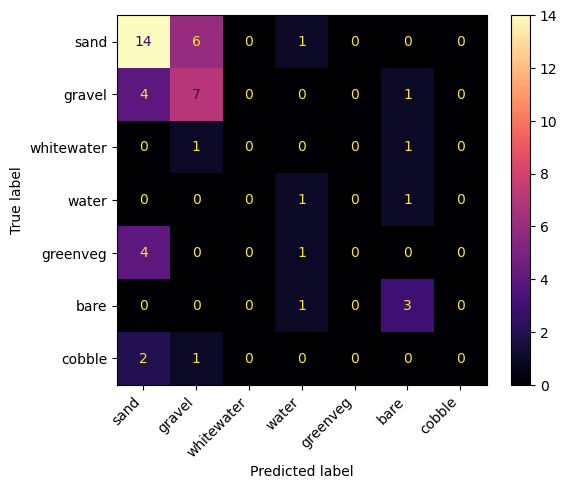

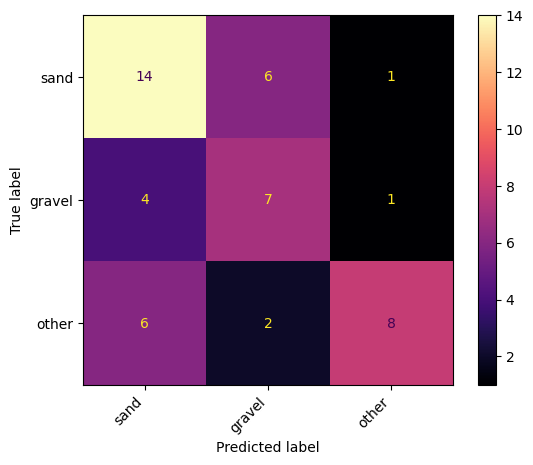

Remapped F1 Score :0.5704 | remapped accuracy score: 0.5918


In [27]:
RF = RandomForestClassifier(n_jobs=-1)

random_search_clf, cm_rand, remapped_cm_rand = random_search_wrapper(RF, X_train, X_test, y_train, y_test, random_grid, n_iter=300, n_splits=5)

In [28]:
def grid_search_wrapper(clf, X_train, X_test, y_train, y_test, param_grid, verbose=3, refit_score='remapped_f1_score', k_fold='normal'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    if k_fold == 'normal':
        skf = KFold(n_splits=10)
    else:
        skf = StratifiedKFold(n_splits=10)
        
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1, verbose=verbose)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)


    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    cm = confusion_matrix(y_test, y_pred)
    print(pd.DataFrame(cm))

    remapped_cm = tv.remap_cm(y_test, y_pred)

    tv.display_cm(cm)
    tv.display_cm(remapped_cm, tv.remapped_class_labels)

    print("Remapped F1 Score (s+g only): {:6.4f} | remapped accuracy score: {:6.4f}".format(tv.remapped_f1_score(y_test, y_pred), tv.remapped_accuracy_score(y_test, y_pred)))
    
    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)
    
    return grid_search, cm, remapped_cm

In [29]:
[int(x) for x in np.linspace(700, 1700, num = 11)]
# [int(x) for x in np.linspace(30, 150, num = 10)]
# [int(x) for x in np.logspace(1.8, 3.33, num = 30)]
# {'n_estimators': 1178, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 89, 'bootstrap': True}

[700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700]

In [30]:
param_grid = {
    'bootstrap': [True], #, False],
    'max_depth': [int(x) for x in np.linspace(50, 250, num = 10)],
    'max_features': [None],
    'min_samples_leaf': [3,4],
    'min_samples_split': [3,4,5,10],
    'n_estimators': [int(x) for x in np.linspace(700, 1700, num = 11)]
    # 'n_estimators': [int(x) for x in np.logspace(1.8, 3.33, num = 30)]
    
}


Fitting 10 folds for each of 880 candidates, totalling 8800 fits
[CV 1/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=700; remapped_accuracy_score: (train=0.822, test=0.750) remapped_f1_score: (train=0.782, test=0.400) total time=   0.6s
[CV 3/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=700; remapped_accuracy_score: (train=0.851, test=0.750) remapped_f1_score: (train=0.827, test=0.417) total time=   0.6s
[CV 6/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=700; remapped_accuracy_score: (train=0.814, test=0.455) remapped_f1_score: (train=0.729, test=0.308) total time=   0.6s
[CV 5/10] END bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=3, n_estimators=700; remapped_accuracy_score: (train=0.863, test=0.545) remapped_f1_score: (train=0.824, test=0.530) total 

,0,1,2
0,15,4,2
1,4,7,1
2,6,2,8


| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.6      | 0.714286 |   0.652174 |        21 |
| gravel  |    0.538462 | 0.583333 |   0.56     |        12 |
| other   |    0.727273 | 0.5      |   0.592593 |        16 |


,class,precision,recall,f1-score,support
0,sand,0.6,0.7142857142857143,0.6521739130434783,21
1,gravel,0.5384615384615384,0.5833333333333334,0.5599999999999999,12
2,other,0.7272727272727273,0.5,0.5925925925925926,16


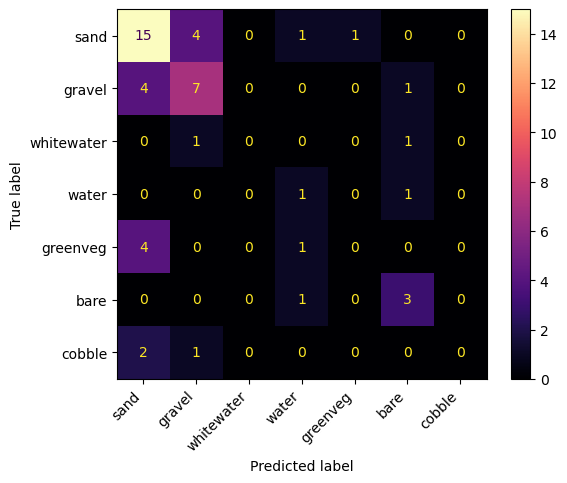

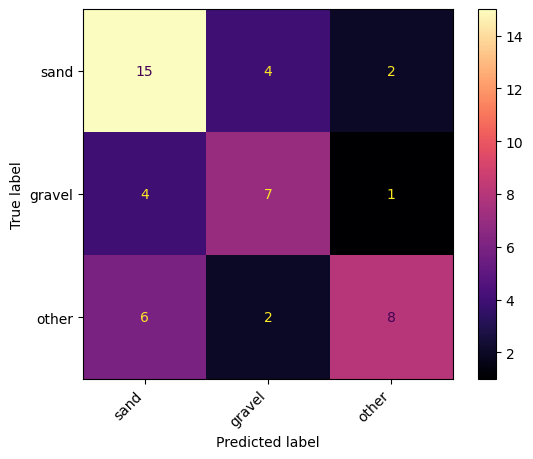

Remapped F1 Score (s+g only): 0.6061 | remapped accuracy score: 0.6122
Best params for remapped_f1_score
{'bootstrap': True, 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 1300}


In [31]:
RF = RandomForestClassifier(n_jobs=-1)
grid_search_clf, cm, remapped_cm = grid_search_wrapper(RF, X_train, X_test, y_train, y_test, param_grid, verbose=3)

In [142]:
grid_search_clf.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 1900}

### Remapped Confusion Matrix

In [144]:
y_pred = grid_search_clf.predict(X_test.values)
remapped_cm = tv.remap_cm(y_test, y_pred)

49


,0,1,2
0,21,0,0
1,3,7,2
2,3,3,10


| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.777778 | 1        |   0.875    |        21 |
| gravel  |    0.7      | 0.583333 |   0.636364 |        12 |
| other   |    0.833333 | 0.625    |   0.714286 |        16 |


,class,precision,recall,f1-score,support
0,sand,0.7777777777777778,1.0,0.8750000000000001,21
1,gravel,0.7,0.5833333333333334,0.6363636363636365,12
2,other,0.8333333333333334,0.625,0.7142857142857143,16


In [145]:
sum(sum(remapped_cm))

49

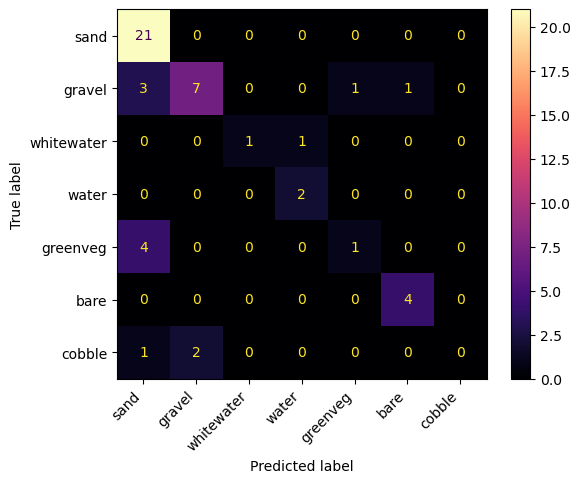

In [50]:
tv.display_cm(cm)

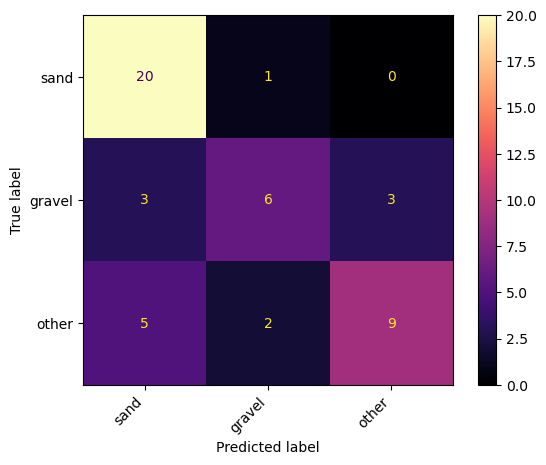

In [51]:
tv.display_cm(remapped_cm, class_labels=['sand','gravel','other'])

# Run some tests on the best model in GEE

### Convert to a GEE model

In [52]:
RF = grid_search_clf.best_estimator_

In [53]:
RF_gee, trees = tv.sklearn_rf_to_gee(RF)

In [54]:
roi = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_aoi')
upper = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_upper_aoi')
lower = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_lower_aoi')
gst = ee.FeatureCollection('projects/gee-sand/assets/ganga_gst_region')


In [55]:
date = '2022-12-07' #from analysis in river_sand_flooding_gst_ganga GEE 
max_search_window_months = 2
median_samples = 5
mosaic_method = 'median'

lon, lat = 78.19376654, 29.74481053
gst_pt = ee.Geometry.Point([lon, lat])

mining_centroids = ee.FeatureCollection('projects/gee-sand/assets/bihar_sand_banks_centroids')

s1_s2 = qm.get_s1_s2(roi=roi, date=date, max_search_window_months=max_search_window_months,median_samples=median_samples, mosaic_method=mosaic_method, clip=False)
s1_s2.bandNames()
roi

Search window from 2022-10-07 to 2023-02-07


In [172]:
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.add_basemap('SATELLITE')
# Map.add_basemap('Stamen.Toner')
Map.addLayer(s1_s2, qm.visParamsVV, 'S1', False)
Map.addLayer(s1_s2, qm.visParamsMTGSI , 'mTGSI', False)
Map.addLayer(s1_s2, qm.visParamsRGB, 'S2')


Map

Map(center=[29.69879481189179, 78.13664798282139], controls=(WidgetControl(options=['position', 'transparent_b…

In [62]:
snicBands = tv.apply_snic(image=s1_s2, roi=roi, size_segmentation=seed_segmentation)
classy_RF = snicBands.classify(RF_gee)
#necessary to keep the final resolution at 10m: not needed if you're zooming around and using interactively
# classy_RF = classy_RF.reproject (crs = classy_RF.projection (), scale = 10)

# classy_RF.getInfo()

Map.addLayer(
    classy_RF,
    tv.classy_vizParams,
    'classification',
)

Map.add_legend(title="Classes", legend_dict=tv.legend_dict, position="bottomright")
sand_gravel = classy_RF.updateMask(classy_RF.eq(1).Or(classy_RF.eq(2)))
Map.addLayer(sand_gravel, tv.classy_vizParams, 'sand_gravel')



# Save To CLoud

In [58]:
model_params = grid_search_clf.best_params_

In [59]:
model_params

{'n_estimators': 1210,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 194,
 'bootstrap': True}

In [60]:
tree_name = 'RF_sklearn_seg{:d}_n{:d}_d{:d}_msl{:d}_mss{:d}_mf-{:s}_b{:s}'.format(seed_segmentation, model_params['n_estimators'], 
                                                                                  model_params['max_depth'], model_params['min_samples_leaf'], 
                                                                                  model_params['min_samples_split'], str(model_params['max_features']), 
                                                                                  str(model_params['bootstrap']))
tree_name

'RF_sklearn_seg10_n1210_d194_msl2_mss3_mf-auto_bTrue'

In [61]:
tv.save_trees_gee(trees,tree_name)

projects/gee-sand/assets/RF_sklearn_seg10_n1210_d194_msl2_mss3_mf-auto_bTrue


In [68]:
cm

array([[21,  0,  0,  0,  0,  0,  0],
       [ 3,  7,  0,  0,  1,  1,  0],
       [ 0,  0,  1,  1,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0],
       [ 4,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  4,  0],
       [ 1,  2,  0,  0,  0,  0,  0]])

In [74]:
sum(sum(cm))

49

In [71]:
remap_cm = tv.remap_cm(cm)


,0,1,2
0,21,0,0
1,3,7,2
2,5,2,8


| class   |   precision |   recall |   f1-score |   support |
|:--------|------------:|---------:|-----------:|----------:|
| sand    |    0.724138 | 1        |   0.84     |        21 |
| gravel  |    0.777778 | 0.583333 |   0.666667 |        12 |
| other   |    0.8      | 0.533333 |   0.64     |        15 |


,class,precision,recall,f1-score,support
0,sand,0.7241379310344828,1.0,0.8400000000000001,21
1,gravel,0.7777777777777778,0.5833333333333334,0.6666666666666666,12
2,other,0.8,0.5333333333333333,0.64,15


In [75]:
sum(sum(remap_cm))

48

## Feature Importance

{'bootstrap': True, 'max_depth': 50, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 1133}

In [206]:
RF = RandomForestClassifier(n_estimators=1133, bootstrap=True, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=2)
RF = RF.fit(X_train, y_train)

In [210]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)


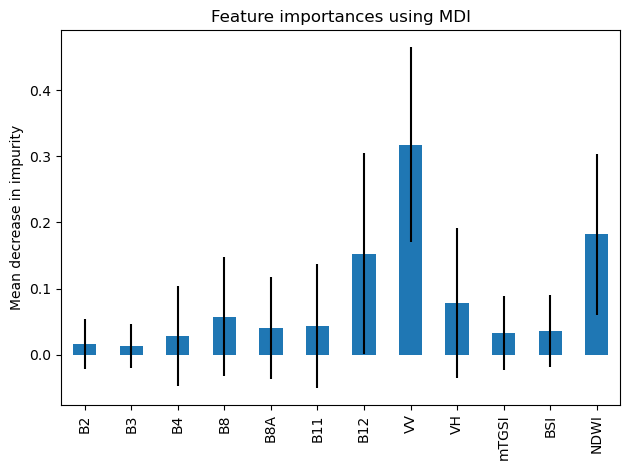

In [211]:
forest_importances = pd.Series(importances, index=qm.USEFUL_BANDS)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Based on feature permutation

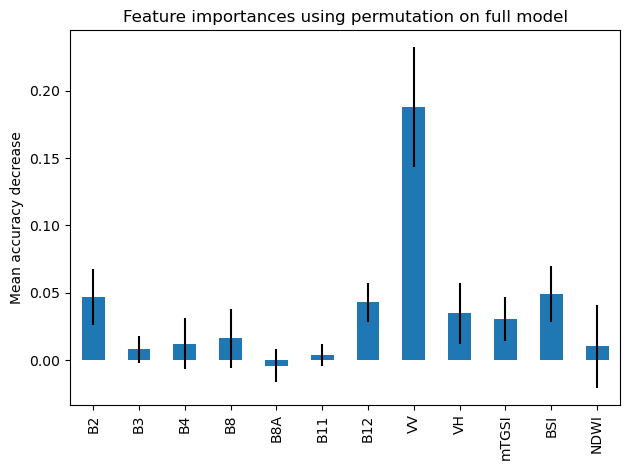

In [212]:
from sklearn.inspection import permutation_importance


result = permutation_importance(
    RF, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=qm.USEFUL_BANDS)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()